In [1]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

In [3]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names\Arabic.txt
data/names\Chinese.txt
data/names\Czech.txt
data/names\Dutch.txt
data/names\English.txt
data/names\French.txt
data/names\German.txt
data/names\Greek.txt
data/names\Irish.txt
data/names\Italian.txt
data/names\Japanese.txt
data/names\Korean.txt
data/names\Polish.txt
data/names\Portuguese.txt
data/names\Russian.txt
data/names\Scottish.txt
data/names\Spanish.txt
data/names\Vietnamese.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [6]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abbas,English
1,Abbey,English
2,Abbott,English
3,Abdi,English
4,Abel,English


In [7]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [8]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [9]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [10]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return np.array(vector)
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [11]:
X = names["name"].map(lambda x: name_representation(x, maxlen))
y = names["lang"].map(lambda x: lang_representation(x, language_to_index))

X = np.stack(X, axis=0)
y = np.stack(y, axis=0)
print("X.shape: ", X.shape, " y.shape: ", y.shape)

### START YOUR CODE
# Shuffle and split names data

n = X.shape[0]
indicies = list(range(n))
np.random.shuffle(indicies)
X = X[indicies]
y = y[indicies]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### END YOUR CODE

X.shape:  (5676, 18, 74)  y.shape:  (5676, 5)


### Utilities

In [12]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [13]:
import sklearn
import pandas as pd

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    nsamples = Y_test.shape[0]
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({languages[i] : cm[:,i] for i in range(len(languages))}, languages)
    return df, cm

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, Dense

### START YOUR CODE

start_power = 5

inp = Input(shape=(None, len_alphabet))

x = SimpleRNN(units=2**start_power, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=False)(inp)
x = Dense(units=5, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inp, outputs=x)

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics="accuracy")
model.summary()

### END YOUR CODE

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 74)]        0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                3424      
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 3,589
Trainable params: 3,589
Non-trainable params: 0
_________________________________________________________________


In [15]:
### START YOUR CODE
batch_size=32
nepochs = 20

log = model.fit(X_train, y_train, batch_size=batch_size, \
                epochs=nepochs, validation_data=(X_test, y_test))

### END YOUR CODE

Epoch 1/20
142/142 [==============================] - 1s 7ms/step - loss: 1.1442 - accuracy: 0.6225 - val_loss: 1.0038 - val_accuracy: 0.6664
Epoch 2/20
142/142 [==============================] - 1s 4ms/step - loss: 0.9658 - accuracy: 0.6733 - val_loss: 0.8497 - val_accuracy: 0.7077
Epoch 3/20
142/142 [==============================] - 1s 4ms/step - loss: 0.8558 - accuracy: 0.7015 - val_loss: 0.7803 - val_accuracy: 0.7245
Epoch 4/20
142/142 [==============================] - 1s 4ms/step - loss: 0.7881 - accuracy: 0.7231 - val_loss: 0.7379 - val_accuracy: 0.7447
Epoch 5/20
142/142 [==============================] - 1s 4ms/step - loss: 0.7449 - accuracy: 0.7361 - val_loss: 0.7046 - val_accuracy: 0.7614
Epoch 6/20
142/142 [==============================] - 1s 4ms/step - loss: 0.7151 - accuracy: 0.7430 - val_loss: 0.6904 - val_accuracy: 0.7667
Epoch 7/20
142/142 [==============================] - 1s 4ms/step - loss: 0.6782 - accuracy: 0.7540 - val_loss: 0.7172 - val_accuracy: 0.7482
Epoch 

Train accuracy (end): 0.8323788642883301
Train accuracy (max): 0.8323788642883301
Test accuracy (end) : 0.7667253613471985
Test accuracy (max) : 0.7808098793029785


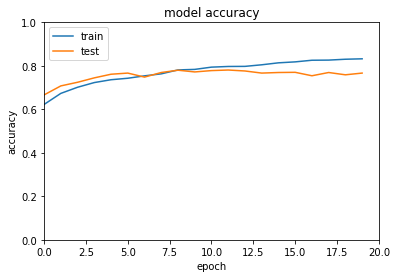

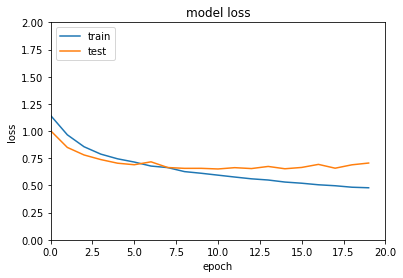

In [16]:
performance_plots(model, X_test, y_test, log, nepochs)

In [17]:
print(classification_report(np.argmax(y_test, axis=-1), np.argmax(model(X_test), axis=-1),
                            target_names=names['lang'].unique()))
df, cm = confusion_matrix(model, X_test, y_test)
df

              precision    recall  f1-score   support

     English       0.81      0.94      0.87       747
      French       0.43      0.07      0.12        43
      German       0.61      0.43      0.50       139
     Italian       0.68      0.69      0.68       150
     Spanish       0.55      0.11      0.18        57

    accuracy                           0.77      1136
   macro avg       0.61      0.45      0.47      1136
weighted avg       0.74      0.77      0.73      1136



,English,French,Italian,German,Spanish
English,699,2,30,15,1
French,30,3,4,6,0
Italian,75,0,60,2,2
German,41,2,2,103,2
Spanish,23,0,3,25,6


Using a larger number of hidden units leads to a better training as well as test accuracy up to some point. At that point (units=`1024`) the accuracy drops drastically. The reason for the drop is obvious when looking at the confusion matrix: The network only predicts the language `English` most probably due to the heavy class imbalance.

### Handle Class Imbalance, Resampling

We can observe a quite significant class imbalance in the data.<br>

One way to compensate for that would be to use resampling.

In [18]:
def handle_imbalance(names, languages, strategy="oversampling"):
    
    ### START YOUR CODE
    lang_length = names_train['lang'].value_counts()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    lang_length.plot(kind='bar', ax=ax1)
    ax1.set_title("Previous distribution")
    
    if strategy == "oversampling":        
        samples_per_class = lang_length[max(lang_length.keys(), key=lambda x: lang_length[x])]
    elif strategy == "undersampling":        
        samples_per_class = lang_length[min(lang_length.keys(), key=lambda x: lang_length[x])]
    
    dfs = []
    for lang in lang_length.keys():
        df = names[names.lang == lang].sample(samples_per_class, replace=True)
        dfs.append(df)

    names_sampled = pd.concat(dfs)
        
    lang_length = names_sampled['lang'].value_counts()
    lang_length.plot(kind='bar', ax=ax2)
    ax2.set_title("Post distribution")
    
    ### END YOUR CODE    
    return names_sampled


<AxesSubplot:>

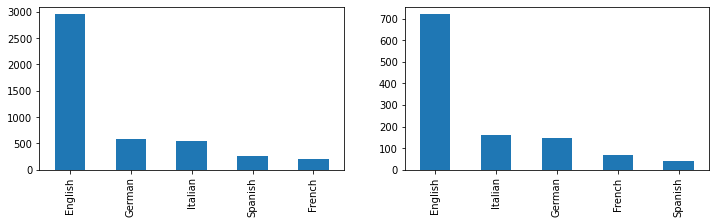

In [19]:
names_train, names_test = train_test_split(names, test_size=0.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
names_train['lang'].value_counts().plot(kind='bar', ax=ax1)
names_test['lang'].value_counts().plot(kind='bar', ax=ax2)

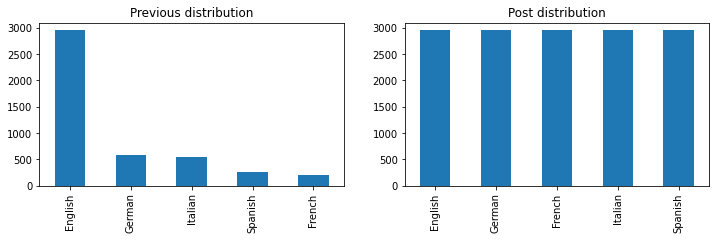

In [20]:
names_train_sampled = handle_imbalance(names_train, languages, strategy="oversampling")

#### Train Model

Again prepare train and test data (X_train, X_test, Y_train, Y_test)

Train the same model as above with the new data.

In [22]:
def map_data(df):
    X = df["name"].map(lambda x: name_representation(x, maxlen))
    y = df["lang"].map(lambda x: lang_representation(x, language_to_index))

    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)
    print("X.shape: ", X.shape, " y.shape: ", y.shape)
    
    return X, y
    
X_train_2, y_train_2 = map_data(names_train_sampled)
X_test_2, y_test_2 = map_data(names_test)

X.shape:  (14745, 18, 74)  y.shape:  (14745, 5)
X.shape:  (1136, 18, 74)  y.shape:  (1136, 5)


In [31]:
### START YOUR CODE

start_power = 5

inp = Input(shape=(None, len_alphabet))

x = SimpleRNN(units=2**start_power, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=False)(inp)
x = Dense(units=5, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inp, outputs=x)

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics="accuracy")
model.summary()


# train model

batch_size=32
nepochs = 20

log = model.fit(X_train_2, y_train_2, batch_size=batch_size, \
                epochs=nepochs, validation_data=(X_test_2, y_test_2))

### END YOUR CODE

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 74)]        0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                3424      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 3,589
Trainable params: 3,589
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
461/461 [==============================] - 2s 4ms/step - loss: 1.2956 - accuracy: 0.4528 - val_loss: 1.2232 - val_accuracy: 0.4296
Epoch 2/20
461/461 [==============================] - 8s 18ms/step - loss: 0.9580 - accuracy: 0.6224 - val_loss: 1.1507 - val_accuracy: 0.4947
Epoch 3/20
461/461 [==============================] - 1s 3ms/step - loss: 0.8169 - accuracy: 0.68

Train accuracy (end): 0.9232282042503357
Train accuracy (max): 0.9235672950744629
Test accuracy (end) : 0.6320422291755676
Test accuracy (max) : 0.6320422291755676


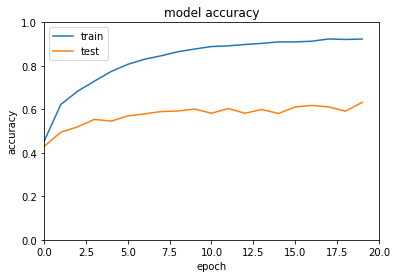

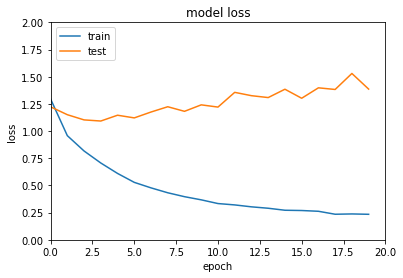

In [32]:
performance_plots(model, X_test_2, y_test_2, log, nepochs)

In [33]:
print(classification_report(np.argmax(y_test_2, axis=-1), np.argmax(model(X_test_2), axis=-1),
                            target_names=names['lang'].unique()))
df, cm = confusion_matrix(model, X_test, y_test_2)
df

              precision    recall  f1-score   support

     English       0.84      0.70      0.76       719
      French       0.18      0.25      0.21        68
      German       0.35      0.53      0.43       147
     Italian       0.68      0.64      0.66       160
     Spanish       0.23      0.36      0.28        42

    accuracy                           0.63      1136
   macro avg       0.46      0.50      0.47      1136
weighted avg       0.69      0.63      0.65      1136



,English,French,Italian,German,Spanish
English,384,60,129,100,46
French,40,5,11,7,5
Italian,80,6,27,20,14
German,81,16,32,16,15
Spanish,17,6,10,6,3


#### Findings

It seems like using the oversampling strategy, we get a test accuracy decrease from `0.77` to `0.63`. When using undersampling the results are even worse. The macro averaged f1 score also decreases, but the classwise f1 score seems to improve in some cases (e.g. For Frensh from `0.11` to `0.21`). As the used model is very limited in terms of capacity, this perfomance decrease could also be due to some kind of underfitting.

#### In which situations is class imbalance treatment important and why?  

If we have an optimization algorithm like gradient descent, it is important that we treat a class imbalance or at least are aware of it when evaluating the results. In gradient descent we continuously nudge the weights in the opposite direction of the gradient. Using stochastic gradient descent we only use a subset of the dataset to approximate this gradient. If we now have a skewed data distribution over the target classes, we get at lot of gradient signals pointing to a local minima where the model will be biased towards a specific class (`English`in this example).

### Implement Model with several SimpleRNN Layers

In [34]:
### START YOUR CODE

start_power = 6

inp = Input(shape=(None, len_alphabet))

x = SimpleRNN(units=2**start_power, activation='tanh', kernel_initializer='glorot_uniform', return_sequences=True)(inp)
x = SimpleRNN(units=2**(start_power+1), activation='tanh', kernel_initializer='glorot_uniform', return_sequences=True)(x)
x = SimpleRNN(units=2**(start_power+2), activation='tanh', kernel_initializer='glorot_uniform', return_sequences=False)(x)
x = Dense(units=5, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inp, outputs=x)

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics="accuracy")
model.summary()


# train model

batch_size=32
nepochs = 20

log = model.fit(X_train_2, y_train_2, batch_size=batch_size, \
                epochs=nepochs, validation_data=(X_test_2, y_test_2))

### END YOUR CODE

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, 74)]        0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, None, 64)          8896      
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, None, 128)         24704     
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 256)               98560     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 133,445
Trainable params: 133,445
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
461/461 [==============================] - 15s 32ms/step - loss: 0.9245 - accuracy: 0.6342 - val_loss:

Train accuracy (end): 0.942488968372345
Train accuracy (max): 0.9578161835670471
Test accuracy (end) : 0.7508803009986877
Test accuracy (max) : 0.7508803009986877


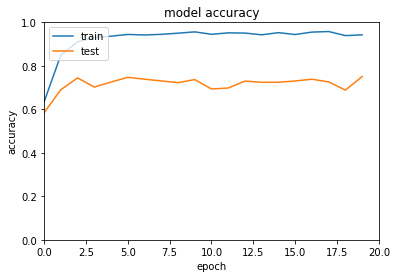

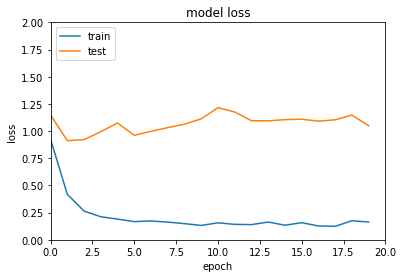

In [35]:
performance_plots(model, X_test_2, y_test_2, log, nepochs)

In [36]:
print(classification_report(np.argmax(y_test_2, axis=-1), np.argmax(model(X_test_2), axis=-1),
                            target_names=names['lang'].unique()))
df, cm = confusion_matrix(model, X_test_2, y_test_2)
df

              precision    recall  f1-score   support

     English       0.86      0.85      0.85       719
      French       0.30      0.26      0.28        68
      German       0.56      0.61      0.58       147
     Italian       0.80      0.74      0.77       160
     Spanish       0.30      0.43      0.35        42

    accuracy                           0.75      1136
   macro avg       0.56      0.58      0.57      1136
weighted avg       0.76      0.75      0.75      1136



,English,French,Italian,German,Spanish
English,609,26,55,14,15
French,27,18,13,6,4
Italian,48,5,90,2,2
German,12,6,3,118,21
Spanish,10,5,1,8,18


#### Findings

Using a larger model with multiple layers and more units per layer enabled a better result on the oversampled dataset. This indicates that the previous metric decrase is due to an underfitting.